## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from decimal import Decimal
#%matplotlib qt
%matplotlib inline

## functions to use

In [2]:
class Line():
    # Define a class to receive the characteristics of each line detection
    def __init__(self):
        #keep track of the last n frames
        self.n=5
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recentxFitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = []  
        #polynomial coefficients of the last n iterations
        self.recentFit = []
        #polynomial coefficients averaged over the last n iterations
        self.bestFit = None  
        #polynomial coefficients for the most recent fit
        self.currentFit = [np.array([False])]  
        #radius of curvature of last n frames
        self.recentRadiusOfCurvature=[]
        #radius of curvature of the line in some units
        self.radiusOfCurvature = None 
        #distance in meters of vehicle center from the line
        self.distanceToCenter = None 
        #fail count
        self.failCount = 0
        #fail count max
        self.failCountMax = 0
        #if use window sliding
        self.useSlidingWindow = True
        
def readCaliPara(file):
    #read the calibration parameter from file
    caliPara = pickle.load(open( file, "rb" ))
    mtx = caliPara['mtx']
    dist = caliPara['dist']
    return mtx, dist

def undistort(img,mtx,dist):
    #undistrot the image with the passed parameters
    return cv2.undistort(img,mtx,dist,None,mtx)

def BGR2HLS(img):
    #convert a BGR image to HLS and return the channels separately
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    return h, l, s

def RGB2HLS(img):
    #convert a RGB image to HLS and return the channels separately
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    return h, l, s

def xSobel(img,thresholdLow, thresholdHigh):
    #apply sobel filter in the x direction
    xSobelAbs = np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0))
    xSobelScaled = np.uint8(255*xSobelAbs/np.max(xSobelAbs))
    xSobelBinary = np.zeros_like(xSobelScaled)
    xSobelBinary[(xSobelScaled >= thresholdLow) & (xSobelScaled <= thresholdHigh)] = 1
    return xSobelBinary

def thresholding(img,thresholdLow,thresholdHigh):
    #apply a simple threashold on a single channel of image
    imgTemp = np.zeros_like(img)
    imgTemp[(img >= thresholdLow) & (img <= thresholdHigh)] = 1
    return imgTemp

def binaryImgOr(img1,img2):
    #pixel-wise AND operation for two singel channel images
    binaryAnd = np.zeros_like(img1)
    binaryAnd[(img1 == 1) | (img2 ==1)] = 1
    return binaryAnd

def binaryImgOr3(img1, img2, img3):
    #pixel-wise AND operation for two singel channel images
    binaryAnd = np.zeros_like(img1)
    binaryAnd[(img1 == 1) | (img2 ==1) | (img3==1)] = 1
    return binaryAnd

def getPerspectiveTransformMatrix(src,dst):
    #get the forward and backward perpective transforamtion matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M, Minv

def showcaseWarp(img,M,src,dst):
    #draw red lines according to the src and dst on the origin and warped image and save them
    [A,B,C,D] = src.astype("int")
    [AP,BP,CP,DP]=dst
    perspectiveSelect = np.copy(img)
    cv2.line(perspectiveSelect, tuple(A), tuple(B), color=[0,0,255],thickness=3)
    cv2.line(perspectiveSelect, tuple(B), tuple(C), color=[0,0,255],thickness=3)
    cv2.line(perspectiveSelect, tuple(C), tuple(D), color=[0,0,255],thickness=3)
    cv2.imwrite('../output_images/perspectiveSelect.jpg',perspectiveSelect)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    cv2.line(warped, tuple(AP), tuple(BP), color=[0,0,255],thickness=3)
    cv2.line(warped, tuple(BP), tuple(CP), color=[0,0,255],thickness=3)
    cv2.line(warped, tuple(CP), tuple(DP), color=[0,0,255],thickness=3)
    cv2.imwrite('../output_images/warped.jpg',warped)

def perspectiveTransform(img,M):
    #warp an image
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped

def histogram(img):
    #return the x-direction histogram of a binary image
    return np.sum(img[img.shape[0]//4:,:], axis=0)

def findBase(histogram):
    #find the left and right lane base base on the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:])+midpoint
    return leftxBase, rightxBase

def slidingWindowLaneFinder(img):
    #get the left and right lanes' coordinates with the method of "sliding window"
    histogramed = histogram(img)
    leftxBase, rightxBase = findBase(histogramed)
    #window parameter
    nwindows = 9
    margin=100
    minpix=50
    windowHeight = np.int(img.shape[0]//nwindows)
    
    #get pixels that are not black
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftxCurrent = leftxBase
    rightxCurrent = rightxBase
    leftLaneInds=[]
    rightLaneInds=[]

    for window in range(nwindows):
        winyLow = img.shape[0] - (window+1)*windowHeight
        winyHigh = img.shape[0] - window*windowHeight
        winxLeftLow = leftxCurrent - margin
        winxLeftHigh = leftxCurrent + margin
        winxRightLow = rightxCurrent - margin
        winxRightHigh = rightxCurrent + margin


        goodLeftInds = ((nonzeroy >= winyLow) & (nonzeroy < winyHigh) & (nonzerox >= winxLeftLow) & (nonzerox < winxLeftHigh)).nonzero()[0]
        goodRightInds = ((nonzeroy >= winyLow) & (nonzeroy < winyHigh) & (nonzerox >= winxRightLow) & (nonzerox < winxRightHigh)).nonzero()[0]

        leftLaneInds.append(goodLeftInds)
        rightLaneInds.append(goodRightInds)

        if len(goodLeftInds) > minpix:
            leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
        if len(goodRightInds) > minpix:
            rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))

    leftLaneInds = np.concatenate(leftLaneInds)
    rightLaneInds = np.concatenate(rightLaneInds)

    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds]
    rightx = nonzerox[rightLaneInds]
    righty = nonzeroy[rightLaneInds]
    
    return leftx,lefty,rightx,righty 

def polynomialLaneFinder(img):
    global leftLine
    global rightLine
    #get the left and right lanes' coordinates with the method of "sliding window"
    histogramed = histogram(img)
    margin=50
    
    #get pixels that are not black
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftLaneInds = ((nonzerox > (leftLine.currentFit[0]*(nonzeroy**2) + leftLine.currentFit[1]*nonzeroy + \
                    leftLine.currentFit[2] - margin)) & (nonzerox < (leftLine.currentFit[0]*(nonzeroy**2) + \
                    leftLine.currentFit[1]*nonzeroy + leftLine.currentFit[2] + margin)))

    rightLaneInds = ((nonzerox > (rightLine.currentFit[0]*(nonzeroy**2) + rightLine.currentFit[1]*nonzeroy + \
                    rightLine.currentFit[2] - margin)) & (nonzerox < (rightLine.currentFit[0]*(nonzeroy**2) + \
                    rightLine.currentFit[1]*nonzeroy + rightLine.currentFit[2] + margin)))

    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds]
    rightx = nonzerox[rightLaneInds]
    righty = nonzeroy[rightLaneInds]
    
    return leftx, lefty, rightx, righty

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def convolutionLaneFinder(img):
    windowWidth = 50
    windowHeight = 80
    margin = 100
    
    windowCentroids = []
    window = np.ones(windowWidth)
    
    lSum = np.sum(img[int(3*img.shape[0]/4):,:int(img.shape[1]/2)], axis=0)
    lCenter = np.argmax(np.convolve(window,lSum))-windowWidth/2
    rSum = np.sum(img[int(3*img.shape[0]/4):,int(img.shape[1]/2):], axis=0)
    rCenter = np.argmax(np.convolve(window,rSum))-windowWidth/2+int(img.shape[1]/2)
    
    windowCentroids.append((lCenter,rCenter))
    
    for level in range(1,(int)(img.shape[0]/windowHeight)):
        # convolve the window into the vertical slice of the image
        imageLayer = np.sum(img[int(img.shape[0]-(level+1)*windowHeight):int(img.shape[0]-level*windowHeight),:], axis=0)
        convSignal = np.convolve(window, imageLayer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = windowWidth/2
        lMinIndex = int(max(lCenter+offset-margin,0))
        lMaxIndex = int(min(lCenter+offset+margin,img.shape[1]))
        lCenter = np.argmax(convSignal[lMinIndex:lMaxIndex])+lMinIndex-offset
        # Find the best right centroid by using past right center as a reference
        rMinIndex = int(max(rCenter+offset-margin,0))
        rMaxIndex = int(min(rCenter+offset+margin,img.shape[1]))
        rCenter = np.argmax(convSignal[rMinIndex:rMaxIndex])+rMinIndex-offset
        # Add what we found for that layer
        windowCentroids.append((lCenter,rCenter))
        
    # Points used to draw all the left and right windows
    lPoints = np.zeros_like(img)
    rPoints = np.zeros_like(img)

    # Go through each level and draw the windows 	
    for level in range(0,len(windowCentroids)):
        # Window_mask is a function to draw window areas
        lMask = window_mask(windowWidth,windowHeight,img,windowCentroids[level][0],level)
        rMask = window_mask(windowWidth,windowHeight,img,windowCentroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        lPoints[(lPoints == 255) | ((lMask == 1) ) ] = 255
        rPoints[(rPoints == 255) | ((rMask == 1) ) ] = 255
        
    lNonzero = lPoints.nonzero()
    lefty = np.array(lNonzero[0])
    leftx = np.array(lNonzero[1])
    
    rNonzero = rPoints.nonzero()
    righty = np.array(rNonzero[0])
    rightx = np.array(rNonzero[1])

    return leftx, lefty, rightx, righty


def regionOfInterest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def gaussianBlur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def updateLines(leftLine,rightLine,leftFit,rightFit,ploty,leftx,lefty,rightx,righty):
    #update data in object leftLine and rightLine, return the best x for left and right line
    leftFitx=leftFit[0]*ploty**2 + leftFit[1]*ploty +leftFit[2]
    rightFitx=rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
    
    if (abs(leftFitx[0]-rightFitx[0]-leftFitx[-1]+rightFitx[-1])<150) \
    & (abs(leftFitx[-1]-rightFitx[-1])<650) & (abs(leftFitx[-1]-rightFitx[-1])>550):

        #set as detected
        leftLine.detected = True
        rightLine.detected = True
        #append the latest x fit
        leftLine.recentxFitted.append(leftFitx)
        rightLine.recentxFitted.append(rightFitx)
        if len(leftLine.recentxFitted) > leftLine.n:
            #if the frame number already exceed, delect the first element
            del leftLine.recentxFitted[0]
            del rightLine.recentxFitted[0]
        #average the x fit over the last frames
        leftLine.bestx = np.mean(leftLine.recentxFitted,0)
        rightLine.bestx = np.mean(rightLine.recentxFitted,0)
        #save the last polynomial coefficients
        leftLine.recentFit.append(leftFit)
        rightLine.recentFit.append(rightFit)
        if len(leftLine.recentFit) > leftLine.n:
            del leftLine.recentFit[0]
            del rightLine.recentFit[0]
        #average the polynomial coefficients over the last frames
        leftLine.bestFit = np.mean(leftLine.recentFit,0)
        rightLine.bestFit = np.mean(rightLine.recentFit,0)
        #save the most current fit
        leftLine.currentFit = leftLine.recentFit[-1]
        rightLine.currentFit = rightLine.recentFit[-1]
        #reset fail count
        leftLine.failCount = 0
        rightLine.failCount = 0
        #dont use sliding window
        leftLine.useSlidingWindow = False
        rightLine.useSlidingWindow = False
        #append new radius of curvature
        xmPerPix=3.7/600
        ymPerPix = 3/90
        leftFitCr = np.polyfit(lefty*ymPerPix, leftx*xmPerPix,2)
        rightFitCr = np.polyfit(righty*ymPerPix, rightx*xmPerPix,2)

        #curvature radius right before the vehicle
        yEval = np.max(ploty)
        leftCurveRad = ((1 + (2*leftFitCr[0]*yEval*ymPerPix + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
        rightCurveRad = ((1 + (2*rightFitCr[0]*yEval*ymPerPix + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])

        leftLine.recentRadiusOfCurvature.append(np.mean([leftCurveRad,rightCurveRad]))
        rightLine.recentRadiusOfCurvature.append(np.mean([leftCurveRad,rightCurveRad]))
        if len(leftLine.recentRadiusOfCurvature) > 10:
            del leftLine.recentRadiusOfCurvature[0]
            del rightLine.recentRadiusOfCurvature[0]
            
        #average radius of curvature over last n frames
        leftLine.radiusOfCurvature = np.mean(leftLine.recentRadiusOfCurvature)
        rightLine.radiusOfCurvature = np.mean(rightLine.recentRadiusOfCurvature)
        #calculate the distance between car center and lane center
        leftLine.distanceToCenter = ((leftFitx[-1]+rightFitx[-1])*0.5 - 640)*xmPerPix
        
    else:
        #set as not detected
        leftLine.detected = False
        rightLine.detected = False
        #increase the fail count
        leftLine.failCount += 1
        rightLine.failCount += 1
        if (leftLine.failCount > leftLine.failCountMax):
            leftLine.useSlidingWindow = True
            rightLine.useSlidingWindow = True
    
    return leftLine.bestx, rightLine.bestx

def lineFinder(img):
    #find lines in the img use sliding window or around the previous fitted polynomial
    if(leftLine.useSlidingWindow):
        lx, ly, rx, ry = slidingWindowLaneFinder(img)
#         lx, ly, rx, ry = convolutionLaneFinder(img)
    else:
        lx, ly, rx, ry = polynomialLaneFinder(img)   
        
    
    return lx,ly,rx,ry

def fitPoly(leftx, lefty, rightx, righty):
    #fit two polynomials with the given data
    leftFit=np.polyfit(lefty,leftx,2)
    rightFit=np.polyfit(righty,rightx,2)
    return leftFit, rightFit

def process_image(img):
    #function to call to process the vedio, a full pipeline is integrated here
    global leftLine
    global rightLine
    
    mtx,dist = readCaliPara("wide_dist_pickle.p")
    #undistor the image
    undistorted = undistort(img, mtx, dist)
    
    #convert it to HLS color space
    hChannel,lChannel,sChannel = RGB2HLS(undistorted)
    
    #gaussian blur
    lChannel = gaussianBlur(lChannel, 3)
    sChannel = gaussianBlur(sChannel, 3)
    hChannel = gaussianBlur(hChannel, 3)

    #apply sobel x filter
    xSobelBinary = xSobel(lChannel,50,100)

    #apply s channel thresholding
    sChannelBinary = thresholding(sChannel, 170, 255)
    
    #apply h channel thresholding, for the yellow lane
    hChannelBinary = thresholding(hChannel, 20, 40)
    
    #combine the two filtered images
    binary = binaryImgOr3(xSobelBinary,sChannelBinary,hChannelBinary)
    
    #black out the pixels with low l value
    binary[(lChannel<30)]=0
    
    #define region of interest
    shape = img.shape
    height = shape[0]
    width = shape[1]
    area = [np.array([[0,height],[int(0.48*width),int(0.585*height)],[int(0.52*width),int(0.585*height)],[width,height]])]
    
    #mask ROI
    binary=regionOfInterest( binary, area )
    
    #calculate warp parameter
    src = np.float32([(180, 720),(580, 458),(700, 458),(1100, 720)])
    dst = np.float32([(330,720),(330,0),(950,0),(950,720)])
    M, Minv = getPerspectiveTransformMatrix(src,dst)

    #warp the binary image, which is the output of the s channel and sobel thresholding
    binaryWarped = perspectiveTransform(binary,M)

    #get left and right lane pixels on the image
    leftx, lefty, rightx, righty = lineFinder(binaryWarped)

    #fit poly for the left and right lane lines
    leftFit, rightFit = fitPoly(leftx, lefty, rightx, righty)

    #plot poly
    ploty = np.linspace(0,img.shape[0]-1,img.shape[0])

    
    leftFitx,rightFitx= updateLines(leftLine,rightLine,leftFit,rightFit,ploty,leftx,lefty,rightx,righty)


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binaryWarped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    lineWarp = np.dstack((warp_zero, warp_zero, warp_zero))
    #paint the left line to red and the right line to blue
    lineWarp[lefty,leftx] = [255,0,0]
    lineWarp[righty,rightx] = [0,0,255]
    lineUnwarp = perspectiveTransform(lineWarp,Minv)
    result = cv2.addWeighted(undistorted, 0.9, lineUnwarp, 1, 0)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspectiveTransform(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(result, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, "Radius of Curvature = "+str(int(leftLine.radiusOfCurvature))+"(m)", \
                (50,50),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,[255,255,255],2)
    if(leftLine.distanceToCenter<=0):
        cv2.putText(result, "Vehicle is  "+str(Decimal(abs(leftLine.distanceToCenter)).quantize(Decimal('0.00')))+\
                    "m left of center", (50,100),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,[255,255,255],2)
    else:
        cv2.putText(result, "Vehicle is  "+str(Decimal(abs(leftLine.distanceToCenter)).quantize(Decimal('0.00')))+\
                    "m left of center", (50,100),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,[255,255,255],2)

    return result

def calibrationParameterGeneration():
    #This function generates parameters for camera calibration, just have to run once. 
    #A file would be generated containing the data: mtx and dist
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

## building pipeline from now on

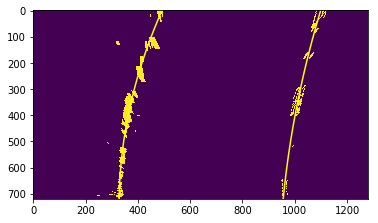

In [36]:
#generate calibration parameter, just have to run once
#calibrationParameterGeneration()

#read image
img = cv2.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../camera_cal/calibration2.jpg')
img = cv2.imread('../test_images/test11.jpg')

#reda calibration parameters
mtx,dist = readCaliPara("wide_dist_pickle.p")

#undistor the image
undistorted = undistort(img, mtx, dist)

cv2.imwrite('../output_images/undistortedtest.jpg',undistorted)

#convert it to HLS color space
hChannel,lChannel,sChannel = BGR2HLS(undistorted)

#apply sobel x filter
xSobelBinary = xSobel(lChannel,50,100)

#apply s channel thresholding
sChannelBinary = thresholding(sChannel, 170, 255)

#apply h channel thresholding
hChannelBinary = thresholding(hChannel,20,40)


#combine the two filtered images
binary = binaryImgOr3(xSobelBinary,sChannelBinary,hChannelBinary)

binary[(lChannel<30)]=0



#cut out the region of interest
shape = img.shape
height = shape[0]
width = shape[1]
area = [np.array([[0,height],[int(0.48*width),int(0.585*height)],[int(0.52*width),int(0.585*height)],[width,height]])]
binary=regionOfInterest( binary, area )

cv2.imwrite('../output_images/binaryresult.jpg',binary*255)

#get perspective transform matrix
src = np.float32([(180, 720),(580, 458),(700, 458),(1100, 720)])
dst = np.float32([(330,720),(330,0),(950,0),(950,720)])
M, Minv = getPerspectiveTransformMatrix(src,dst)

#save warped version of the undistoted image
showcaseWarp(undistorted,M,src,dst)

#warp the binary image, which is the output of the s channel and sobel thresholding
binaryWarped = perspectiveTransform(binary,M)

cv2.imwrite('../output_images/binarywarped.jpg',binaryWarped*255)

#get left and right lane pixels on the image
leftx, lefty, rightx, righty = slidingWindowLaneFinder(binaryWarped)

#construct a image for visualising the lane lines
outImg = np.dstack((binaryWarped,binaryWarped,binaryWarped))
outImg[lefty,leftx]=[255,0,0]
outImg[righty,rightx]=[0,0,255]

#fit poly for the left and right lane lines
leftFit = np.polyfit(lefty,leftx,2)
rightFit = np.polyfit(righty,rightx,2)

#plot poly
ploty = np.linspace(0,outImg.shape[0]-1,outImg.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty +leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
plt.plot(leftFitx,ploty,color='yellow')
plt.plot(rightFitx,ploty,color='yellow')

#define the relation between the actual length and pixel
xmPerPix=3.7/600
ymPerPix = 3/90

#fit poly in real world
leftFitCr = np.polyfit(lefty*ymPerPix, leftx*xmPerPix,2)
rightFitCr = np.polyfit(righty*ymPerPix, rightx*xmPerPix,2)

#curvature radius right before the vehicle
yEval = np.max(ploty)
left_curverad = ((1 + (2*leftFitCr[0]*yEval*ymPerPix + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
right_curverad = ((1 + (2*rightFitCr[0]*yEval*ymPerPix + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])

warp_zero = np.zeros_like(binaryWarped).astype(np.uint8)
lineWarp = np.dstack((warp_zero, warp_zero, warp_zero))
lineWarp[lefty,leftx] = [255,0,0]
lineWarp[righty,rightx] = [0,0,255]
plt.imshow(thresholding(lChannel, 70, 255))
plt.imshow(binaryWarped)
# cv2.imwrite('../output_images/linewarp.jpg',lineWarp)



In [3]:
leftLine = Line()
rightLine = Line()
lastLeftFitx=[]
lastRightFitx=[]
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("../project_video.mp4")#.subclip(20,30)
# clip1 = VideoFileClip("../project_video.mp4").subclip(35,45)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [02:55<00:00,  7.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2min 56s
